# COGS 108 - Final Project 

# Overview

There are a surprising number of parks in San Diego. Many of them are rated on Yelp, and this analysis will look to discover the relationship between the overall rating of the park with the popularity of that park; measured in terms of how many people left a review. Many parks will not have many reviews, so in which case we will attempt to build a predictor that will predict rating based on review text so in the future in-person comments or other forms of feedback can be incorporated with Yelp reviews to better gauge the quality of these parks.

As it will turn out, the majority of the highest rated parks will have less than 30 reviews while the more popular ones will be rated at about a half of a star or a full star less. We will also be unable to build a quality predictor because our review texts are truncated; leaving us with a predictor that attempts to predict rating based on just the first portion of the review. This predictor will be a little better than trivial, and it's accuracy decreases if we try to include a bag of words representation of the truncated text as a feature.

# Name & GitHub

- Name: Dominic Simone
- GitHub Username: DominicSimone

# Research Question

Are the most popular parks rated as the highest quality? In the case of parks with very few ratings, if people tend to avoid submitting online ratings, can we get feedback from people at the park and estimate a rating from that feedback? In more practical terms, how good of a predictor can we build that predicts rating based on review text?

## Background and Prior Work

Using Yelp data to create predictors is not a new task, and it has been used successfully in the past to achieve pretty high accuracies [1]. This article uses scraped Yelp data to create a predictor that predicts restaurant rating from review text using sentiment analysis and bag of word features to achieve a 97% accurate model, which has the potential to be overfit. We will use similar methods in this analysis to create a predictor to predict park rating from review text.

Unfortunately, it seems as though our dataset is somewhat small. It could be the case that not many people leave reviews on Yelp about parks. There are other ways to predict visitor satisfaction outside of reading reviews hosted on a third party site. In a study that collected responses to questionnaires from visitors, many categories of park attributes are identified that are predictive of a visitors satisfaction, with the most predictive category being maintenance of the park [2]. This includes no litter, no vandalism, working restrooms, clean benches, things that have to do with the physical well being of the park. To better understand the quality of San Diego's parks, it would be a good idea to go beyond Yelp reviews and, like in the paper linked in [2], serve questionnaires to visitors themselves and gather more detailed feedback that way.

Using the types of park data and questionnaire results used in that study would create a much more accurate model than the one created in this analysis. However, we don't have the time or financial budget to accomodate such an in-depth approach and will be sticking with Yelp reviews.

References:
- 1) Web Scraping Yelp, Text Mining and Sentiment Analysis for Restaurant Reviews 
    - https://medium.com/@kborole7/web-scraping-yelp-text-mining-and-sentiment-analysis-for-restaurant-reviews-ea500e1ef84d
- 2) Manageable Predictors of Park Visitor Satisfaction: Maintenance and Personnel
    - http://staff.washington.edu/kwolf/Archive/Classes/ESRM304_SocSci/304%20Soc%20Sci%20Lab%20Articles/Fletcher_2003.pdf

# Hypothesis


On the subject of popularity, I would expect that the more popular parks (parks with the highest number of ratings) would tend to be higher rated, as more people are attending these parks. 

On the subject of predictors, I would also expect that features derived from review text would be a good predictor of the rating associated with that review text.

# Dataset(s)

**San Diego Parks Yelp Data**
   - Yelp Data for San Diego Parks
       - Source: https://www.yelp.com/ (Prof Ellis curated this data)
       - Dataset (CSV, Park Information): yelp_SD_parks.csv  
            - This data set contains 2333 samples of yelp reviews that are made of id, rating and text pairs. The id represents the park that was rated, the rating is on a scale from 1 to 5, and the text is the text of the review.
       - Dataset (CSV, Reviews): yelp_SD_reviews.csv
           - This data set contains 832 rows of park information that corresponds to the previous review information, and the data we are using are	name, overall rating, and review count for every national park.

# Setup

In [1]:
import random
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from collections import defaultdict
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Data Cleaning

The dictionary data required very little cleaning; we only needed to drop a row where the park was closed as well as drop a number of unused columns for convenience.

In [3]:
df_yelp = pd.read_csv('../data/yelp_SD_reviews.csv')
df_yelp_dict = pd.read_csv('../data/yelp_SD_parks.csv')

df_yelp_dict = df_yelp_dict[df_yelp_dict['is_closed'] == False]
df_yelp_dict = df_yelp_dict.drop(['phone', 'id', 'address', 'url', 'is_closed'], axis=1)

The review data was not missing any values and no review was left blank, so no cleaning needed to be done here.

In [4]:
print(df_yelp.isna().any())
df_yelp[df_yelp['text'] == '']

id        False
rating    False
text      False
dtype: bool


,id,rating,text


For some use later in the analysis, we need to derive the sentiment from all the review text.

In [5]:
analyzer = SentimentIntensityAnalyzer()
polarities = [analyzer.polarity_scores(d) for d in df_yelp['text']]
df_yelp['neg'] = [p['neg'] for p in polarities]
df_yelp['pos'] = [p['pos'] for p in polarities]
df_yelp['neu'] = [p['neu'] for p in polarities]
df_yelp['compound'] = [p['compound'] for p in polarities]

In [6]:
df_yelp.head(1)

,id,rating,text,neg,pos,neu,compound
0,Balboa Park,5,Balboa Park is a must see when coming to San D...,0.0,0.091,0.909,0.4215


Also construct a bag of words representation of the reviews to use in our predictor later.

In [7]:
wordCount = defaultdict(int)
totalWords = 0

punct = string.punctuation
stemmer = PorterStemmer()

for d in df_yelp['text'].values:
    t = d.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        #w = stemmer.stem(w)
        totalWords += 1
        wordCount[w] += 1

In [8]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
counts[:3]

[(2976, 'the'), (2205, 'and'), (2108, 'a')]

In [9]:
# Use the top 100-1000 words 
words = [w[1] for w in counts[100:1000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

# Data Analysis & Results

### Exploratory Data Analysis


Basic shape and layout of our two related datasets.

In [10]:
print(df_yelp_dict.shape)
df_yelp_dict.head(2)

(832, 5)


,name,rating,review_count,longitude,latitude
0,Balboa Park,5.0,2105,-117.153150,32.734502
1,Civita Park,4.5,46,-117.147278,32.778315


In [11]:
print(df_yelp.shape)
df_yelp.head(2)

(2333, 7)


,id,rating,text,neg,pos,neu,compound
0,Balboa Park,5,Balboa Park is a must see when coming to San D...,0.0,0.091,0.909,0.4215
1,Balboa Park,5,Beautiful grounds even to take a stroll during...,0.0,0.379,0.621,0.9001


---
Overall distribution of individual ratings; most people gave 5 stars with the fewest number of people giving 2 stars. This is surprising as I would expect the most common review to be either 3 or 4 stars. Either the San Diego parks are high quality or park attendees tend to give high reviews.

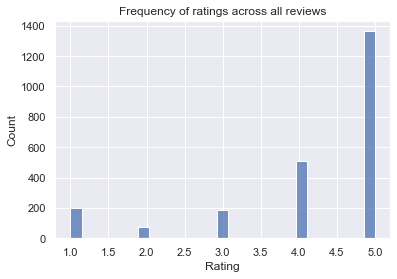

In [12]:
ax = sns.histplot(df_yelp['rating'].values)
ax.set_xlabel('Rating')
_ = ax.set_title('Frequency of ratings across all reviews')

Distribution of parks overall ratings; most were between 3.5 to 5 stars with very few under 3 stars. This is a somewhat expected result based on the last graph as most reviews were either 4 or 5 stars.

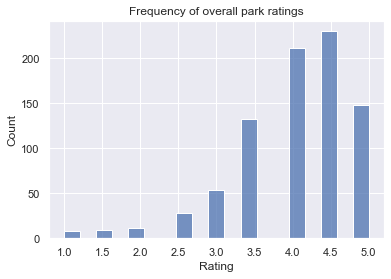

In [13]:
ax = sns.histplot(df_yelp_dict['rating'].values)
ax.set_xlabel('Rating')
_ = ax.set_title('Frequency of overall park ratings')

Distribution of the number of reviews; very few parks had over 200 reviews

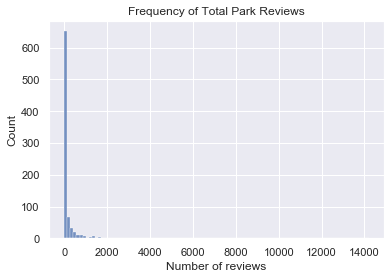

In [14]:
# Distribution of the number of reviews; very few parks had over 200 reviews
ax = sns.histplot(df_yelp_dict['review_count'].values, bins=100)
ax.set_title('Frequency of Total Park Reviews')
_ = ax.set_xlabel('Number of reviews')

Looking in more detail, it looks like 75% of parks had less than 110 reviews, and 50% had less than 22. With 832 parks total, this means that over 400 parks had less than 22 reviews total. There are a few reasons why this could be the case. These parks could be smaller and less attended and thus have less reviews, this dataset could be incomplete or from an unknown time frame, or maybe people don't leave park reviews on yelp particularly often. This would be a good section for future investigation.

In [15]:
df_yelp_dict['review_count'].describe()

count      832.000000
mean       201.486779
std        745.191428
min          1.000000
25%          6.000000
50%         22.000000
75%        109.000000
max      14195.000000
Name: review_count, dtype: float64

How does the number of reviews relate to the rating? Seems like there are plenty of high quality parks that have low review counts. However, this is not super clear with the wide range of review counts.

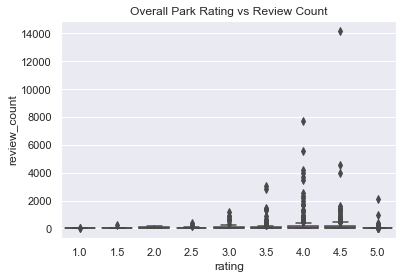

In [16]:
ax = sns.boxplot(data=df_yelp_dict, y='review_count', x='rating')
_ = ax.set_title('Overall Park Rating vs Review Count')

Cut off the extreme review count scores and it seems like many five star parks had very few reviews. So it seems like the answer to our question of 'Are the most rated parks rated the highest?' as no, since the majority of 5 star parks have fewer than 100 reviews.

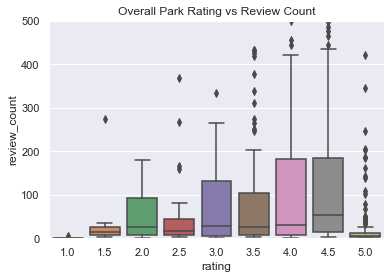

In [17]:
ax = sns.boxplot(data=df_yelp_dict, y='review_count', x='rating')
ax.set_ylim([0, 500])
_ = ax.set_title('Overall Park Rating vs Review Count')

How does positivity of the review text relate to the rating? Turns out, it's not as direct of a relationship as expected which doesn't bode well for our future predictor. There is a lot of overlap in each of the boxplots, so having a high positivity score on a review doesn't necessarily mean that the review gave a high rating.


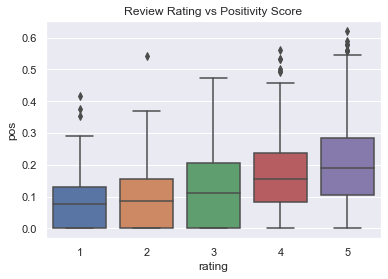

In [18]:
ax = sns.boxplot(data=df_yelp, x='rating', y='pos')
_ = ax.set_title('Review Rating vs Positivity Score')

### Analysis

Let's see if we can build a multi-layer perceptron predictor out of the review text that can correctly predict rating from input text. I will shuffle the input data and use 90% of it for training, and 10% of it for testing.

In [19]:
def text(t):
    feat = [0]*len(wordSet)
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if not (w in wordSet): continue
        feat[wordId[w]] += 1
    feat.append(1)
    return feat

In [21]:
feat = []
rows = df_yelp.values
for i in range(len(rows)):
    r = [rows[i][1], 1, polarities[i]['pos'], *text(rows[i][2])]
    feat.append(r)

In [25]:
random.shuffle(feat)
X = [f[1:] for f in feat]
y = [f[0] for f in feat]

Xtrain = X[:int(len(X) * 0.9)]
Xtest = X[int(len(X) * 0.9):]

ytrain = y[:int(len(y) * 0.9)]
ytest = y[int(len(y) * 0.9):]

In [36]:
mod = MLPRegressor()
mod_text = MLPRegressor()
mod.fit([d[1:3] for d in Xtrain], ytrain)
mod_text.fit(Xtrain, ytrain)

MLPRegressor()

In [37]:
pred = mod.predict([d[1:3] for d in Xtest])
pred_text = mod_text.predict(Xtest)

print('Positivity only r2 score: ', r2_score(ytest, pred))
print('Positivity + bag of words r2 score: ', r2_score(ytest, pred_text))

Positivity only r2 score:  0.07157124030740891
Positivity + bag of words r2 score:  -0.36747831125977237


With a test set R^2 score of only about 0.09, our model manages to capture about 9% of the variation in the data. This is pretty bad, and tells us that our predictor is not much better than just predicting the average all the time. Adding in a bag of words representation of the text on top of the positive sentiment score worsens the accuracy of the model. There are a few problems with our model. Most notably, the text data looks like the following:

In [34]:
df_yelp['text'].values[0]

"Balboa Park is a must see when coming to San Diego. If you are a resident, it's nice to realize that every time you do come here, there are different things..."

In [33]:
n = 0
for t in df_yelp['text'].values:
    if t[-3:] == '...':
        n += 1
n / len(df_yelp)

0.9322760394342049

In these reviews we see that 93% of reviews  are truncated, leaving an unknown amount of text out of each review. This excluded text could be very important to the overall meaning of each review and is affecting the accuracy of our model with respect to both the sentiment analyzer and the bag of words representation. This is likely why we are seeing such low accuracies from our text-derived predictor, as well as a decrease in accuracy when we try to incorporate a bag of words representation of the text into our model.

We saw in the exploratory data analysis that the parks with the most reviews were not the highest rated; in fact, the heavy majority of 5 star parks received less than 30 reviews each. We also saw that building a predictor based on this text data is a flawed approach since so much of the text is truncated to an unknown degree. In order to build a more insightful analysis, we would need additional data.

# Ethics & Privacy

This data was retrieved by Prof Ellis through Yelp's API, and as such we have full permission to use it for non-commercial use according to their Terms of Use.

There is no PII in this dataset, and there is no date associated with each review that could link the review to one specific person. 

We saw in our exploratory analysis that the majority of reviews were a 5. This is a genuine bias that influences our analysis, but not in a significant way.

Since we are not drawing conclusions about who is likely to attend a park and since we have no data about the individuals who left each review, we don't need to worry about excluding particular populations. There is likely a section of the population that is more likely to go or more able to go to a state park but we are unable to determine what it is from this data. This is not problematic for this analysis.

# Conclusion & Discussion

We were able to answer both of our research questions with this analysis.

We saw in the exploratory data analysis that most national parks had less than 22 reviews, and that most parks with an overall rating of 5 stars had less than 30 reviews, while the more popular ones will be rated at about a half of a star or a full star less. So from this data, we can tell that there are a number of high quality parks that have far fewer visitors than perhaps they deserve.

We were also be unable to build a quality predictor because our review texts are truncated; leaving us with a predictor that attempts to predict rating based on just the first portion of the review. This was a huge limitation of this project and makes predictions with text derived features not viable. In order to make a predictor like this possible, we would need a more complete set of text feedback.

Knowing these two conclusions, it would seem that many high quality parks are either not getting the visitation they deserve or not getting enough online feedback. In the former case, it would be beneficial to advertise these parks to the surrounding area or make them more accessible to increase the number of visitors, which would benefit both the visitors and the parks themselves. The visitors get to experience high quality parks and the parks may be able to get more funding as more people enjoy them or financially support them through merchandise or vote for budget increases.